# CoRaLS Monte Carlo acceptance model 

This will step through a the main Monte Carlo model and plot some results.

In [ ]:
# Import and compile modules - slow the first time you run on a fresh kernel
using CoRaLS
using ProgressMeter
using PyPlot
using LaTeXStrings
using DelimitedFiles
using Unitful: km, sr, EeV, MHz, m, μV, cm

In [6]:
# Number of trials and energy bins in each run
ntrials = 100_000  # Baseline test: 100_000
nbins = 10  # Baseline test: 20

altitude = 30.0km
ice_depth = 6.0m

# Acceptance run (adapted from test/study_tests.jl)
A = acceptance( ntrials, nbins; 
                altitude=altitude, 
                ice_depth=ice_depth,
                min_energy=1.0EeV,
                ν_max=1000MHz,
                dν = 30MHz,
                trigger=gaussian_trigger(sqrt(1000 / 300.)*0.5*67μV/m),
                save_events=false)

E_bins = 18.0 .+ log10.(0.5*(A.energies[1:end-1] + A.energies[2:end]) / 1.0EeV)
A_direct = A.dAΩ / 1km^2 / 1sr
A_reflected = A.rAΩ / 1km^2 / 1sr;  # semicolon suppresses output

┌ Info: Calculating acceptance using 100000 trials across 10 bins...
└ @ CoRaLS /home/cjtu/projects/CoRaLS.jl/src/acceptance.jl:41


Simulating...  20%|███████▋                              |  ETA: 0:01:52

Simulating...  30%|███████████▍                          |  ETA: 0:01:37

Simulating...  40%|███████████████▎                      |  ETA: 0:01:23

Simulating...  50%|███████████████████                   |  ETA: 0:01:09

Simulating...  60%|██████████████████████▊               |  ETA: 0:00:55

Simulating...  70%|██████████████████████████▋           |  ETA: 0:00:41

Simulating...  80%|██████████████████████████████▍       |  ETA: 0:00:28

Simulating...  90%|██████████████████████████████████▎   |  ETA: 0:00:14

Simulating... 100%|██████████████████████████████████████| Time: 0:02:17


10-element Vector{Float64}:
   1.4002749047923695
   7.216801432391443
  15.941591223790054
  36.29943407038681
  73.35286232027721
 140.45834429609613
 230.29136511123738
 375.27367448435507
 564.6339269939693
 785.8773619511637

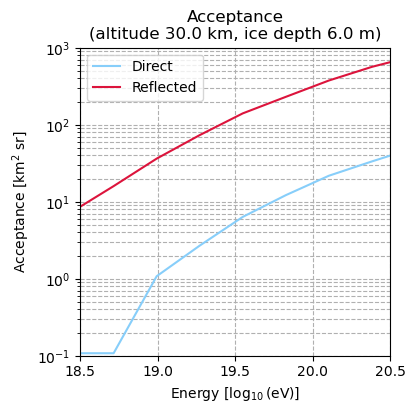

In [30]:
# Plot results
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(E_bins, A_direct, label="Direct", c="lightskyblue", ls="solid")
ax.plot(E_bins, A_reflected, label="Reflected", c="crimson", ls="solid")

ax.set( xlabel=L"Energy [$\log_{10}$(eV)]", 
        ylabel=L"Acceptance [km$^2$ sr]",
        xlim=[18.5, 20.5],
        ylim=[1e-1, 1e3],
        yscale="log", 
        title="Acceptance\n(altitude "*string(altitude)*", ice depth "*string(ice_depth)*")")
ax.set_axisbelow(true)
ax.grid(which="both", linestyle="dashed")
ax.legend()
gcf()  # Shows the figure in the notebook

## Breaking down model components

**Coming soon**